In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [7]:
df = pd.read_csv("prices.csv", index_col = 0)
df["adj close"] = df.close 
df.drop(['close'], 1, inplace=True) 
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05 00:00:00,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06 00:00:00,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07 00:00:00,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08 00:00:00,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11 00:00:00,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [8]:
symbols = list(set(df.symbol))
len(symbols)

501

In [5]:
symbols = list(set(df.symbol))
df = df[df.symbol == 'MSFT']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,30.620001,30.590000,31.100000,38409100.0,30.950001
2010-01-05,30.850000,30.639999,31.100000,49749600.0,30.959999
2010-01-06,30.879999,30.520000,31.080000,58182400.0,30.770000
2010-01-07,30.629999,30.190001,30.700001,50559700.0,30.450001
2010-01-08,30.280001,30.240000,30.879999,51197400.0,30.660000


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.184785,0.193215,0.190780,0.096490,0.195518
2010-01-05,0.190429,0.194444,0.190780,0.132965,0.195765
2010-01-06,0.191166,0.191495,0.190289,0.160088,0.191086
2010-01-07,0.185031,0.183383,0.180971,0.135571,0.183206
2010-01-08,0.176442,0.184612,0.185385,0.137622,0.188377


In [6]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) 
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) 
    train = result[:int(row), :] 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))   
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))  
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [8]:
window = 30
X_train, y_train, X_test, y_test = load_data(df, window)

C:\Users\Aadesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Compilation Time :  0.019946813583374023


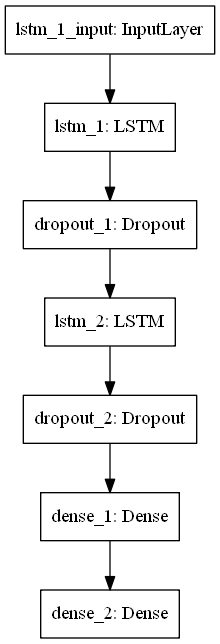

In [9]:
model = build_model([5,window,1])
plot_model(model)

In [10]:

model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1402 samples, validate on 156 samples
Epoch 1/100
1402/1402 [==============================] - 5s 4ms/step - loss: 0.0946 - accuracy: 7.1327e-04 - val_loss: 0.4191 - val_accuracy: 0.0000e+00
Epoch 2/100
1402/1402 [==============================] - 3s 2ms/step - loss: 0.0546 - accuracy: 7.1327e-04 - val_loss: 0.1057 - val_accuracy: 0.0000e+00
Epoch 3/100
1402/1402 [==============================] - 3s 2ms/step - loss: 0.0322 - accuracy: 7.1327e-04 - val_loss: 0.1260 - val_accuracy: 0.0000e+00
Epoch 4/100
1402/1402 [==============================] - 3s 2ms/step - loss: 0.0166 - accuracy: 7.1327e-04 - val_loss: 0.1644 - val_accuracy: 0.0000e+00
Epoch 5/100
1402/1402 [==============================] - 3s 2ms/step - loss: 0.0139 - accuracy: 7.1327e-04 - val_loss: 0.0531 - val_accuracy: 0.0000e+00
Epoch 6/100
1402/1402 [==============================] - 3s 2ms/step - loss: 0.0076 - accuracy: 7.1327e-04 - val_loss: 0.0257 - val_accuracy: 0.0000e+00
Epoch 7/100
1402/1402 [============

In [51]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

(173, 1)


-3.33437457515074
[0.7057791948318481, 0.6966055035591125, 0.6859327554702759, 0.6738239526748657, 0.6610602140426636, 0.6502888202667236, 0.6411488056182861, 0.6337184309959412, 0.6285082101821899, 0.6256076693534851, 0.6250894665718079, 0.6268490552902222, 0.6309160590171814, 0.636491060256958, 0.6427216529846191, 0.6489647626876831, 0.6541250348091125, 0.6576059460639954, 0.659076452255249, 0.6596336364746094, 0.6586542129516602, 0.6578545570373535, 0.6586019992828369, 0.6595900058746338, 0.6614164113998413, 0.6640018224716187, 0.6672089695930481, 0.670242965221405, 0.6723556518554688, 0.6742764115333557, 0.6756693124771118, 0.6762791872024536, 0.6758756637573242, 0.6742211580276489, 0.6684277057647705, 0.6614587306976318, 0.6541226506233215, 0.6473419666290283, 0.6414281129837036, 0.6371132135391235, 0.6348854303359985, 0.6349401473999023, 0.6373629570007324, 0.636728048324585, 0.6343267560005188, 0.6319103240966797, 0.6313698291778564, 0.6329361200332642, 0.6363869309425354, 0.640

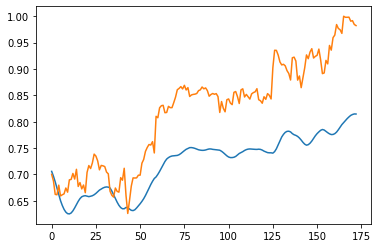

In [52]:
print(r2_score(temp,y_test))
print(temp)
plt.plot(temp)
plt.plot(y_test)

In [53]:
df = pd.read_csv("prices.csv", index_col = 0)
df["adj close"] = df.close
df.drop(['close'], 1, inplace=True)
df = df[df.symbol == 'MSFT']
df.drop(['symbol'],1,inplace=True)
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [54]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print()
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00096 MSE (0.03 RMSE)
Test Score: 0.01206 MSE (0.11 RMSE)



(0.0009576758284322601, 0.012055787564702117)

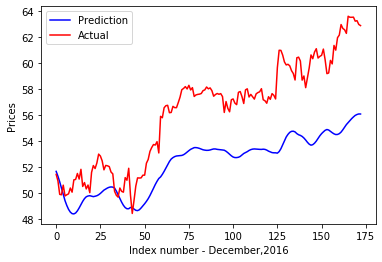

In [55]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='blue', label='Prediction')
plt2.plot(newy_test,color='red', label='Actual')
plt2.legend(loc='best')
plt2.xlabel('Index number - December,2016')
plt2.ylabel('Prices')
plt2.show()

In [56]:
newy_test=newy_test[153:]
newp=newp[153:]

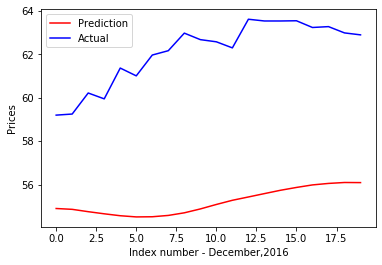

In [57]:
plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.xlabel('Index number - December,2016')
plt2.ylabel('Prices')
plt2.show()

In [58]:
trange = pd.date_range('2016-12-1', periods=20, freq='d')
trange

DatetimeIndex(['2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
               '2016-12-05', '2016-12-06', '2016-12-07', '2016-12-08',
               '2016-12-09', '2016-12-10', '2016-12-11', '2016-12-12',
               '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16',
               '2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20'],
              dtype='datetime64[ns]', freq='D')

In [59]:
Predict_df = pd.DataFrame(newp, index=trange)
Predict_df.columns = ['forecast']
Predict_df

,forecast
2016-12-01,54.895611
2016-12-02,54.856934
2016-12-03,54.749134
2016-12-04,54.651016
2016-12-05,54.562382
2016-12-06,54.507740
2016-12-07,54.515244
2016-12-08,54.576317
2016-12-09,54.696808
2016-12-10,54.875572


In [60]:
actual_df = pd.DataFrame(newy_test, index=trange)
actual_df.columns = ['actual']
actual_df

,actual
2016-12-01,59.200001
2016-12-02,59.250000
2016-12-03,60.220001
2016-12-04,59.950001
2016-12-05,61.369999
2016-12-06,61.009998
2016-12-07,61.970001
2016-12-08,62.169998
2016-12-09,62.980000
2016-12-10,62.680000


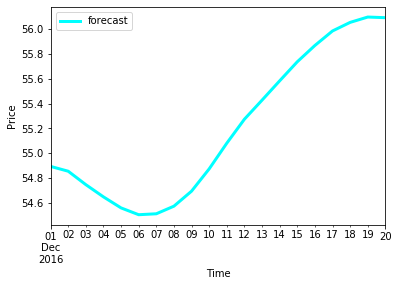

In [61]:
Predict_df.plot(color='cyan', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

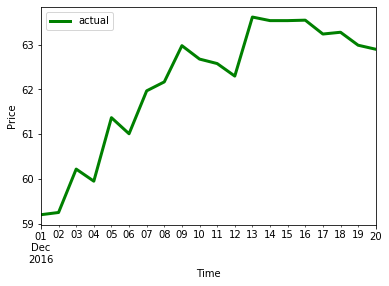

In [62]:
actual_df.plot(color='green', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()